In [85]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log, log10

energies = []
crossections = []

file = open("ion-ss-cs-10.dat")

energies_tmp = []
crossections_tmp = []

for line in file:
    lineSplit = line.split()

    energy = float(lineSplit[0])
    crossection = float(lineSplit[1])

    if energy == -1 and crossection == -1:
        energies.append(tuple(energies_tmp))
        crossections.append(tuple(crossections_tmp))

        energies_tmp.clear()
        crossections_tmp.clear()

        continue

    if energy == -2 and crossection == -2:
        break

    energies_tmp.append(energy)
    crossections_tmp.append(crossection)

file.close()

def calcCrossection(E:float, energies:np.array, crossections:np.array):

    if E < energies[0]: return 0
    elif E > energies[-1]: return crossections[-1]

    indArr1 = np.sum(energies <= E)-1
    indArr2 = energies.size  - np.sum(energies >= E)

    if indArr1 == indArr2: return crossections[indArr1]

    sigma1 = crossections[indArr1]
    E1 = energies[indArr1]

    sigma2 = crossections[indArr2]
    E2 = energies[indArr2]

    logSigma = ( log(sigma1) * log(E2/E) + log(sigma2) * log(E/E1) )/log(E2/E1)
    return np.exp(logSigma)


energies_arr = np.logspace(np.log10(1.996e-05), np.log10(1e+05), 100000)
crossections0_arr = np.array([ calcCrossection(energies_arr[i], np.array(energies[0]), np.array(crossections[0])) for i in range(energies_arr.size)  ])
crossections1_arr = np.array([ calcCrossection(energies_arr[i], np.array(energies[1]), np.array(crossections[1])) for i in range(energies_arr.size)  ])
crossections2_arr = np.array([ calcCrossection(energies_arr[i], np.array(energies[2]), np.array(crossections[2])) for i in range(energies_arr.size)  ])
crossections3_arr = np.array([ calcCrossection(energies_arr[i], np.array(energies[3]), np.array(crossections[3])) for i in range(energies_arr.size)  ])



/tmp/ipykernel_3972/3662313143.py:52: RuntimeWarning: divide by zero encountered in log
  logSigma = ( log(sigma1) * log(E2/E) + log(sigma2) * log(E/E1) )/log(E2/E1)


In [86]:


crossectionsTotal_arr = crossections0_arr+crossections1_arr+crossections2_arr+crossections3_arr

print(f"=================\n meanCrossection = {calcCrossection(0.01, energies_arr, crossectionsTotal_arr)}  \n=================")

 meanCrossection = 6908526.740806407  


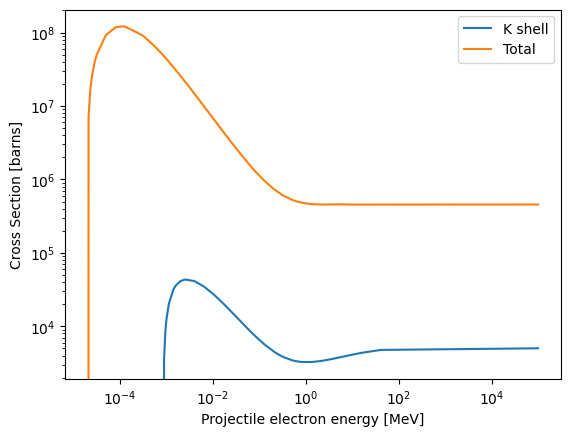

In [118]:
plt.plot(energies_arr, crossections0_arr, label="K shell")
# plt.plot(energies_arr, crossections1_arr, label="L1")
# plt.plot(energies_arr, crossections2_arr, label="L2")
# plt.plot(energies_arr, crossections3_arr, label="L3")
# plt.plot(energies_arr, crossections1_arr+crossections2_arr+crossections3_arr, label="L shell")
plt.plot(energies_arr, crossections0_arr+crossections1_arr+crossections2_arr+crossections3_arr, label="Total")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Cross Section [barns]")
plt.xlabel("Projectile electron energy [MeV]")
plt.legend()


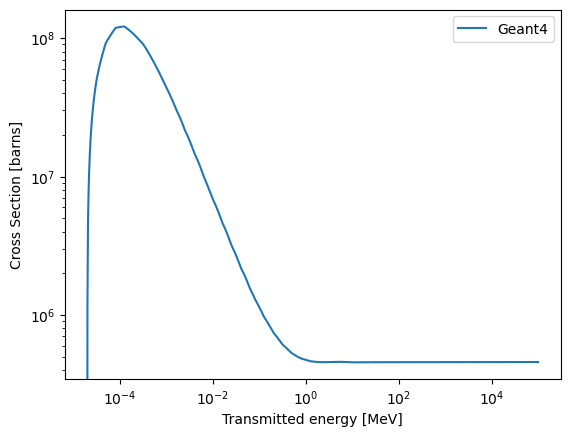

In [88]:
#this cell plots data obrained from Geant4

file = open("Geant4Crossection.txt")

energies_g4_plot = []
sigmas_g4_plot = []

for line in file:

    lineSplit = line.split()

    energies_g4_plot.append(float(lineSplit[0]))
    sigmas_g4_plot.append(float(lineSplit[1]))

plt.plot(energies_g4_plot, sigmas_g4_plot, label="Geant4")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Cross Section [barns]")
plt.xlabel("Transmitted energy [MeV]")
plt.legend()

Text(0.5, 0, 'Secondary electrons kinetic energy [MeV]')

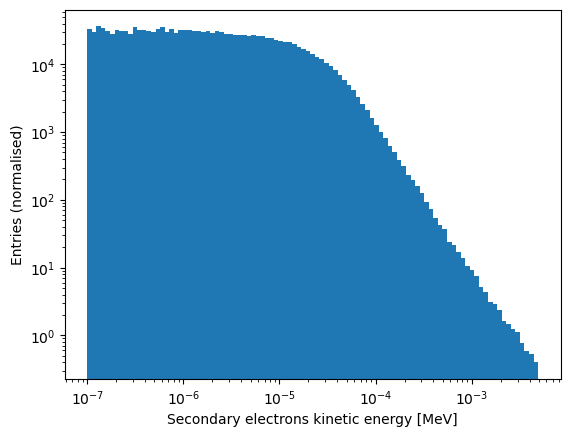

In [89]:
import uproot

flat_tree = uproot.open("Secondaries.root")['Secondaries']
df = flat_tree.arrays(library="np")
flat_tree.close()

df["Ekin"] = df["Ekin"]/1000 #keV to MeV

bins_arr = np.logspace(log10(min(df["Ekin"])), log10(max(df["Ekin"])), 100)

plt.hist(df["Ekin"], bins=bins_arr, density=True)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Entries (normalised)")
plt.xlabel("Secondary electrons kinetic energy [MeV]")

In [90]:
#This cell will read data about delta electrons production

file = open("ion-sp-10.dat")

delta_data_by_shels = []

binding_energy = [8.702000e-04, 4.850000e-05, 2.170000e-05, 2.160000e-05] # MeV

energies = []
parameters = []

i = 0
for line in file:

    lineSplit = line.split()

    if i % 2 == 0:
        
        if lineSplit[0] == "-1" and "-1" == lineSplit[1]:
            delta_data_by_shels.append({"energies": tuple(energies), "parameters":tuple(parameters), "binding_energy":binding_energy.pop(0)})
            energies.clear()
            parameters.clear()
            i = 0
            continue
        elif lineSplit[0] == "-2" and "-2" == lineSplit[1]:
            break

        energies.append(float(lineSplit[0]))
        parameters.append([float(lineSplit[1])])
    else:
        parameters[-1].extend([float(el) for el in lineSplit])

    i+=1

file.close()



In [99]:
from math import log

def get_dsigmadt(T, t, shelIdx):
    ''' 
         T & t in MeV units
    '''

    def calculate_dsigmadt_from_pars(pars, binding_e):
        
        energy = T + binding_e

        A = pars[0]/energy
        x0 = pars[1]/energy
        x1 = pars[2]/energy
        x2 = min(pars[3]/energy, 0.5)

        gLocal3 = energy / 0.511 + 1.
        g = (2.0 * gLocal3 - 1.0) / (gLocal3 * gLocal3)

        x = (t + binding_e)/energy

        if x < x0: return 0
        elif x > 0.5: return 0
        elif x <= x1:
            d = (x1-x0)/3
            n = -100

            for k in range(4):
                if (x-x0)/d - 1 < k and k <= (x-x0)/d:

                    if k == (x-x0)/d: return pars[k+4]

                    n = k
                    break

            x1i = x0 + d*n
            x2i = x0 + d*(n+1)
            y1i = pars[n+4]
            y2i = pars[n+4+1]

            return ((y2i-y1i)/(x2i-x1i)*x + (x2i*y1i-x1i*y2i)/(x2i-x1i))/x**2
        elif x <= x2:
            d = (x2/x1)**(1/16)
            m = -100

            for k in range(0,16):
                if log(x/x1, d) - 1 <= k and k < log(x/x1, d):

                    if k == log(x/x1, d) - 1: return pars[k+7]

                    m = k
                    break

            x1i = x1*d**m
            x2i = x1*d**(m+1)
            y1i = pars[m+7]
            y2i = pars[m+7+1]

            return ((y2i-y1i)/(x2i-x1i)*x + (x2i*y1i-x1i*y2i)/(x2i-x1i))/x**2
        else:
            return (1 - g*x + (1-g)*x**2 + x**2/(1-x) * (1/(1-x)-g) + A*(0.5-x)/x)/x**2


    energies = np.array(delta_data_by_shels[shelIdx]["energies"])
    parameters = delta_data_by_shels[shelIdx]["parameters"]
    binding_energy = delta_data_by_shels[shelIdx]["binding_energy"]


    if T < energies[0]: return 0
    assert T < energies[-1], "The E value is out of provided data range"

    indArr1 = np.sum(energies <= T)-1
    indArr2 = energies.size  - np.sum(energies >= T)

    if indArr1 == indArr2: return calculate_dsigmadt_from_pars(parameters[indArr2], binding_energy)
    else:
        x1 = energies[indArr1]
        x2 = energies[indArr2]

        parametersInterp = ( np.log(parameters[indArr1]) * log(x2/t) + np.log(parameters[indArr2]) * log(t/x1) )/log(x2/x1)
        parametersInterp = np.exp(parametersInterp)

        return calculate_dsigmadt_from_pars(parametersInterp, binding_energy)
        


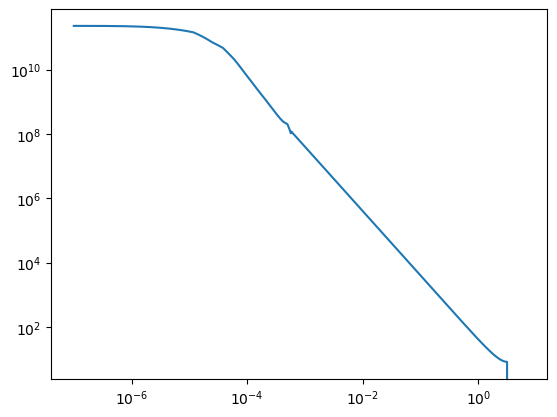

In [100]:
x_plot = np.logspace(-7, np.log10(6.3096), 1000)
# x_plot = np.logspace(-7, log10(max(df["Ekin"])), 1000)

y_plot = np.array([get_dsigmadt(6.3096, x_plot[i], 3) for i in range(x_plot.size)])

plt.plot(x_plot, y_plot)
plt.yscale("log")
plt.xscale("log")

dsig_dt_tot_norm =  6908526.740796247


/tmp/ipykernel_3972/3329384966.py:80: RuntimeWarning: divide by zero encountered in log
  parametersInterp = ( np.log(parameters[indArr1]) * log(x2/t) + np.log(parameters[indArr2]) * log(t/x1) )/log(x2/x1)


Text(0.5, 0, 'Secondary electrons kinetic energy [MeV]')

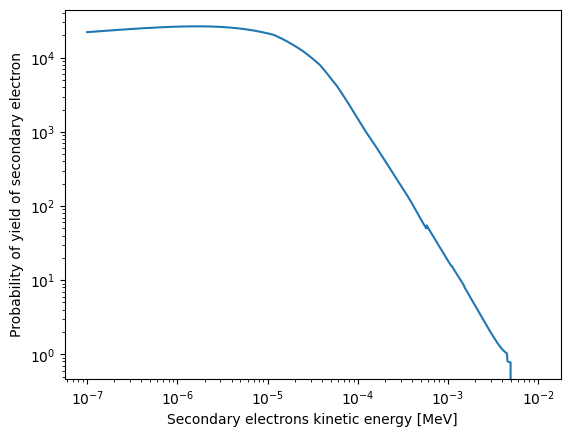

In [101]:
import scipy.integrate as integrate

T = 0.01

sigmaShell0 = calcCrossection(T, energies_arr, crossections0_arr)
sigmaShell1 = calcCrossection(T, energies_arr, crossections1_arr)
sigmaShell2 = calcCrossection(T, energies_arr, crossections2_arr)
sigmaShell3 = calcCrossection(T, energies_arr, crossections3_arr)

t_arr = np.logspace(-7, np.log10(T), 1000)

dsig_dt0 =  np.array([get_dsigmadt(T, t_arr[i], 0) for i in range(t_arr.size)])
dsig_dt1 =  np.array([get_dsigmadt(T, t_arr[i], 1) for i in range(t_arr.size)])
dsig_dt2 =  np.array([get_dsigmadt(T, t_arr[i], 2) for i in range(t_arr.size)])
dsig_dt3 =  np.array([get_dsigmadt(T, t_arr[i], 3) for i in range(t_arr.size)])

dsig_dt0 = dsig_dt0/integrate.simps(dsig_dt0,t_arr)
dsig_dt1 = dsig_dt1/integrate.simps(dsig_dt1,t_arr)
dsig_dt2 = dsig_dt2/integrate.simps(dsig_dt2,t_arr)
dsig_dt3 = dsig_dt3/integrate.simps(dsig_dt3,t_arr)

dsig_dt_tot = dsig_dt0*sigmaShell0 + dsig_dt1*sigmaShell1 + dsig_dt2*sigmaShell2 + dsig_dt3*sigmaShell3

dsig_dt_tot_norm = integrate.simps(dsig_dt_tot,t_arr)
print("dsig_dt_tot_norm = ", dsig_dt_tot_norm) 
dsig_dt_tot = dsig_dt_tot/dsig_dt_tot_norm
#normalise dsig_dt_tot so that it became a probability density function

plt.plot(t_arr, dsig_dt_tot)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Probability of yield of secondary electron")
plt.xlabel("Secondary electrons kinetic energy [MeV]")

Text(0.5, 1.0, 'Database data')

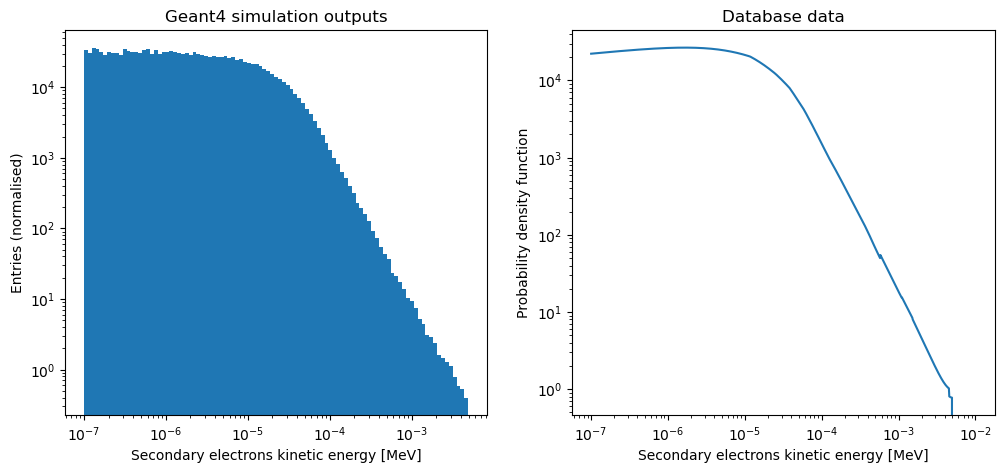

In [119]:
#getting the simulation output histogram and theoretical line in the same canvas

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
ax1.hist(df["Ekin"], bins=bins_arr, density=True)
ax1.set_yscale("log")
ax1.set_xscale("log")

ax1.set_ylabel("Entries (normalised)")
ax1.set_xlabel("Secondary electrons kinetic energy [MeV]")
ax1.set_title("Geant4 simulation outputs")


ax2.plot(t_arr, dsig_dt_tot)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel("Probability density function")
ax2.set_xlabel("Secondary electrons kinetic energy [MeV]")
ax2.set_title("Database data")

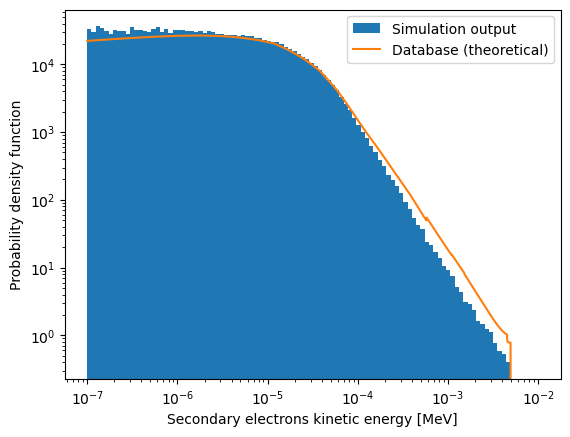

In [113]:
#with the same axis

plt.hist(df["Ekin"], bins=bins_arr, density=True, label="Simulation output")
plt.plot(t_arr, dsig_dt_tot, label="Database (theoretical)")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Probability density function")
plt.xlabel("Secondary electrons kinetic energy [MeV]")
plt.legend()